In [2]:
# !pip install --upgrade pip
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install monai==1.1.0 scikit-image scikit-learn pandas tqdm matplotlib seaborn SimpleITK nibabel matplotlib pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 104.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.6/317.6 kB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 106.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.5/226.5 kB 78.5 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.3.0
    Uninstalling Pillow-9.3.0:
      Successfully uninstalled Pillow-9.3.0

[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
# Cell 1 - run once
# Uncomment if libs missing
# !pip install -U monai==1.1.0 torch torchvision simpleitk matplotlib tqdm

import os, sys, time, math
from pathlib import Path
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import monai
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged,
    Spacingd, Resized, RandFlipd, RandRotate90d, ToTensord
)
from monai.data import CacheDataset, Dataset
from monai.networks.nets import UNet
from monai.metrics import DiceMetric
from monai.losses import DiceLoss

import SimpleITK as sitk


In [17]:
# Cell 2
DATA_ROOT = Path("preprocessed_fleischner_fixed")  # old dataset root used earlier
OUTPUT_DIR = DATA_ROOT / "runpod_outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

SEG_META_PATH = DATA_ROOT / "metadata_fleischner_final.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("DATA_ROOT:", DATA_ROOT)

# load metadata quickly for inspection
# meta = pd.read_csv(META_PATH)
seg_meta = pd.read_csv(SEG_META_PATH)

seg_meta["image"] = seg_meta["image"].apply(fix_path)
seg_meta["mask"]  = seg_meta["mask"].apply(fix_path)

# meta["image"] = meta["image"].apply(fix_path)
# meta["mask"]  = meta["mask"].apply(fix_path)


print("Total meta seg rows:", len(seg_meta))


Device: cuda
DATA_ROOT: preprocessed_fleischner_fixed
Total meta seg rows: 1084


In [7]:
def fix_path(p):
    # normalize slashes
    p = str(p).replace("\\", "/")
    # take only the part AFTER "preprocessed_fleischner/"
    if "preprocessed_fleischner_fixed/" in p:
        p = p.split("preprocessed_fleischner_fixed/")[1]
    # rebuild absolute path
    return str(DATA_ROOT / p)

In [4]:
seg_meta

,uid,image,mask,diameter_mm,texture_code,texture_class,fleischner_7class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,5.651471,5.0,ground-glass,3
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,4.224708,5.0,ground-glass,3
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,5.786348,5.0,ground-glass,3
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,8.143262,5.0,ground-glass,6
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,18.545150,5.0,ground-glass,6
...,...,...,...,...,...,...,...
1079,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,5.053694,5.0,ground-glass,3
1080,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,4.556101,5.0,ground-glass,3
1081,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,4.357368,5.0,ground-glass,3
1082,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,4.277203,5.0,ground-glass,3


In [5]:
# Cell 3
# MONAI expects dict entries e.g. {'image': path, 'mask': path}
seg_df = seg_meta.copy()
# adapt your exact column names if different
# if "image_path" in seg_df.columns:
#     seg_df = seg_df.rename(columns={"image_path":"image"})
# if "mask_path" in seg_df.columns:
#     seg_df = seg_df.rename(columns={"mask_path":"mask"})

# normalize Windows backslashes and make absolute
seg_df["image"] = seg_df["image"].astype(str).apply(lambda p: os.path.normpath(p))
seg_df["mask"]  = seg_df["mask"].astype(str).apply(lambda p: os.path.normpath(p))

# quick check single sample
print(seg_df[["image","mask"]].iloc[0].to_dict())


{'image': 'preprocessed_fleischner_fixed/images/1_3_6_1_4_1_14519_5_2_1_6279_6001_100225287222365663678666836860_0000.nii.gz', 'mask': 'preprocessed_fleischner_fixed/masks/1_3_6_1_4_1_14519_5_2_1_6279_6001_100225287222365663678666836860_0000_mask.nii.gz'}


In [6]:
# Cell 4
# Use Resized to enforce cubic shape in loader so DataLoader stacking is always possible
train_trans = Compose([
    LoadImaged(keys=["image","mask"]),
    EnsureChannelFirstd(keys=["image","mask"]),
    # Optional: if you want to force 1mm spacing, keep Spacingd; else remove it
    # Spacingd(keys=["image","mask"], pixdim=(1.0,1.0,1.0), mode=("bilinear","nearest")),

    # Important: intensity scaling from HU to [0,1] if your saved patches are HU
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-1000.0, a_max=400.0,
        b_min=0.0, b_max=1.0, clip=True
    ),

    # Force uniform shape 64x64x64 for both image & mask
    Resized(
    keys=["image"],
    spatial_size=(64, 64, 64),
    mode="trilinear"
        ),
        
    Resized(
    keys=["mask"],
    spatial_size=(64, 64, 64),
    mode="nearest"
    ),


    # Augmentations
    RandFlipd(keys=["image","mask"], prob=0.5, spatial_axis=0),
    RandRotate90d(keys=["image","mask"], prob=0.5, spatial_axes=(0,1)),

    ToTensord(keys=["image","mask"])
])

val_trans = Compose([
    LoadImaged(keys=["image","mask"]),
    EnsureChannelFirstd(keys=["image","mask"]),
    ScaleIntensityRanged(keys=["image"], a_min=-1000.0, a_max=400.0, b_min=0.0, b_max=1.0, clip=True),
    Resized(keys=["image","mask"], spatial_size=(64,64,64), mode=("trilinear","nearest")),
    ToTensord(keys=["image","mask"])
])


In [7]:
# Cell 5
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(seg_df, test_size=0.2, random_state=42, shuffle=True)
print("Train:", len(train_df), "Val:", len(val_df))

train_ds = CacheDataset(data=train_df.to_dict("records"), transform=train_trans, cache_rate=1.0)
val_ds   = CacheDataset(data=val_df.to_dict("records"), transform=val_trans, cache_rate=1.0)

# If memory is low, set cache_rate=0.2 or use monai.data.Dataset instead
print("CacheDataset created. Train size:", len(train_ds), "Val size:", len(val_ds))


Train: 867 Val: 217


Loading dataset: 100%|██████████| 217/217 [00:04<00:00, 50.95it/s]

CacheDataset created. Train size: 867 Val size: 217


In [8]:
# Cell 6
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)
val_loader   = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True, prefetch_factor=2)

In [9]:
# Cell 7
unet = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16,32,64,128),
    strides=(2,2,2),
    num_res_units=2
).to(device)

# Stable loss: dice + BCEWithLogits
bce = torch.nn.BCEWithLogitsLoss()
dice = DiceLoss(sigmoid=True)   # from monai.losses
def combined_loss(pred, target, bce_w=0.5):
    l_d = dice(pred, target)
    l_b = bce(pred, target)
    return bce_w * l_b + (1.0 - bce_w) * l_d

optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)

dice_metric = DiceMetric(include_background=False, reduction="mean")


In [10]:
def show_prediction(img, mask, pred, slice_idx=None):
    """
    img, mask, pred are tensors of shape (1,64,64,64)
    """

    img  = img.squeeze(0).cpu().numpy()   # (64,64,64)
    mask = mask.squeeze(0).cpu().numpy()
    pred = pred.squeeze(0).cpu().numpy()

    if slice_idx is None:
        slice_idx = img.shape[0] // 2

    fig, ax = plt.subplots(1,3, figsize=(14,4))

    ax[0].imshow(img[slice_idx], cmap="gray")
    ax[0].set_title("Image")

    ax[1].imshow(img[slice_idx], cmap="gray")
    ax[1].imshow(mask[slice_idx], cmap="Reds", alpha=0.5)
    ax[1].set_title("GT Mask")

    ax[2].imshow(img[slice_idx], cmap="gray")
    ax[2].imshow(pred[slice_idx], cmap="Blues", alpha=0.5)
    ax[2].set_title("Pred Mask")

    plt.show()


Epoch 1 train:   0%|          | 0/434 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1386: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1386: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1386: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. Th

Epoch 1/40 | TrainLoss=0.8075 | ValDice=0.0071 | time=27.4s


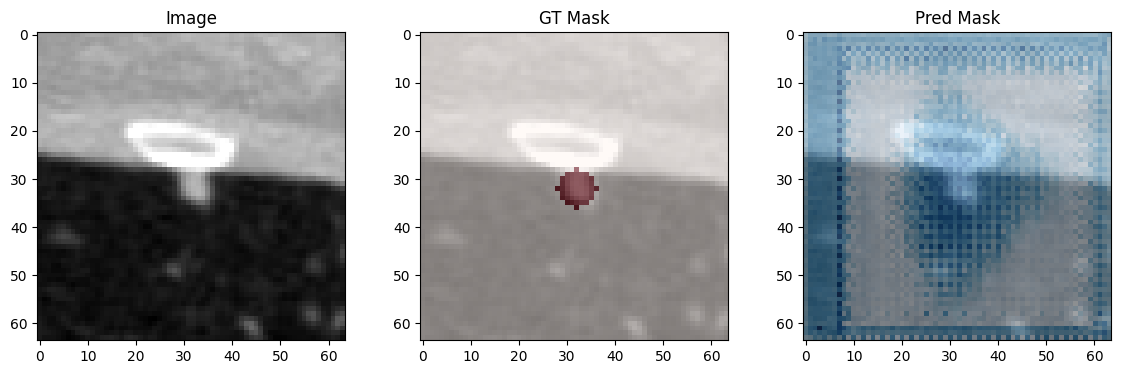

🔥 Saved NEW BEST model (val dice improved)


Epoch 2 val: 100%|██████████| 109/109 [00:04<00:00, 22.60it/s]


Epoch 2/40 | TrainLoss=0.7029 | ValDice=0.0097 | time=25.7s


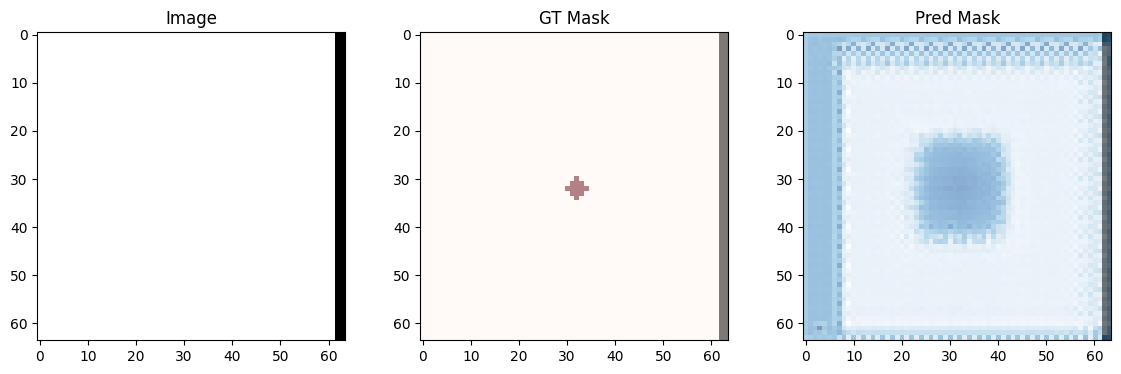

🔥 Saved NEW BEST model (val dice improved)


Epoch 3 val: 100%|██████████| 109/109 [00:04<00:00, 22.03it/s]


Epoch 3/40 | TrainLoss=0.6399 | ValDice=0.0114 | time=25.6s


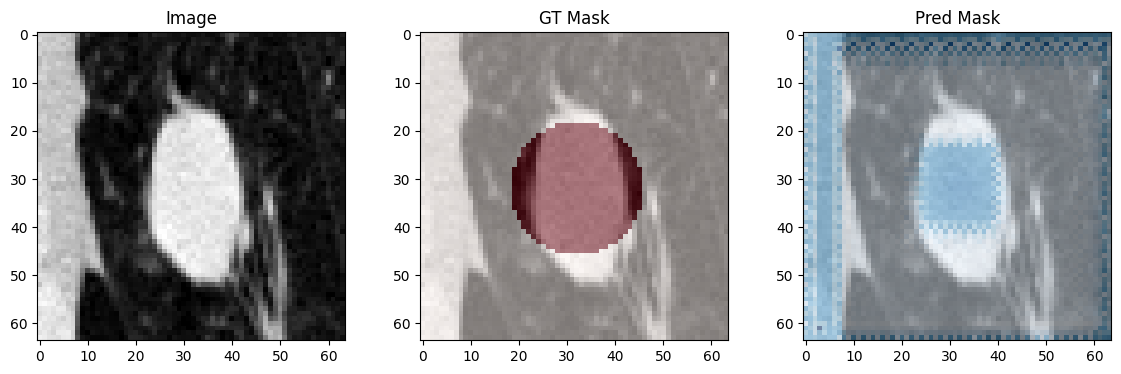

🔥 Saved NEW BEST model (val dice improved)


Epoch 4 val: 100%|██████████| 109/109 [00:04<00:00, 22.76it/s]


Epoch 4/40 | TrainLoss=0.5980 | ValDice=0.0124 | time=26.3s


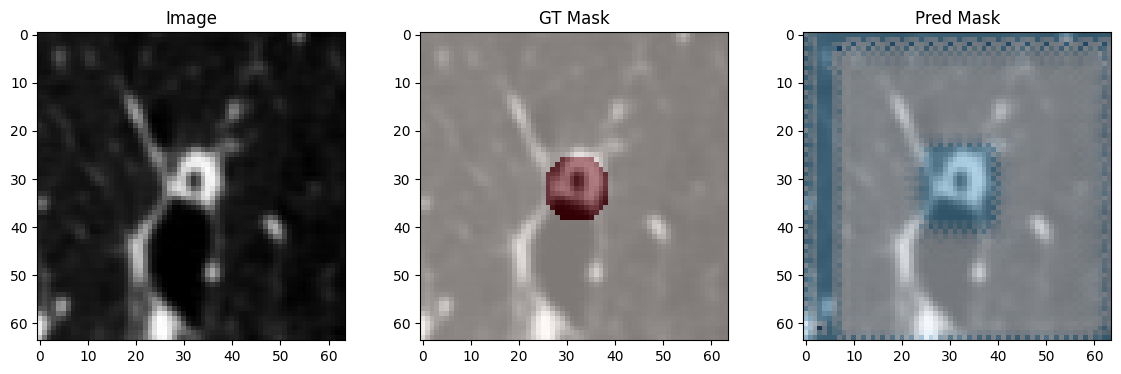

🔥 Saved NEW BEST model (val dice improved)


Epoch 5 val: 100%|██████████| 109/109 [00:04<00:00, 23.51it/s]


Epoch 5/40 | TrainLoss=0.5681 | ValDice=0.0148 | time=25.3s


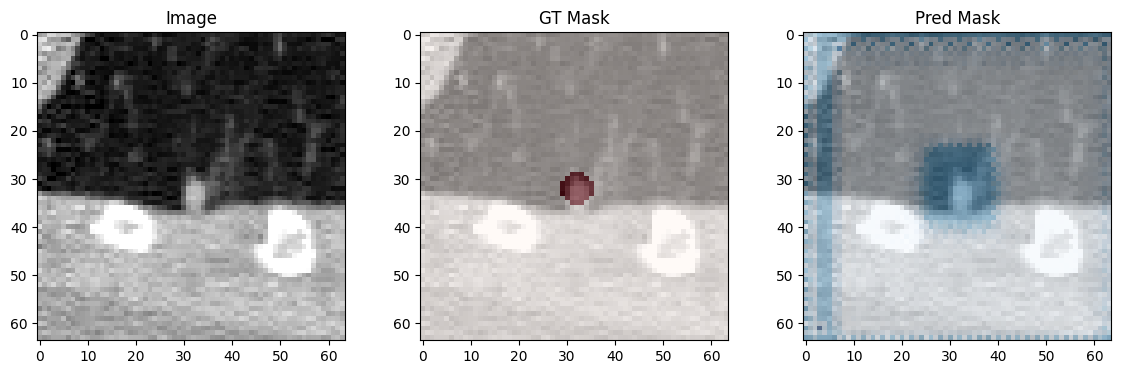

🔥 Saved NEW BEST model (val dice improved)


Epoch 6 val: 100%|██████████| 109/109 [00:05<00:00, 21.77it/s]


Epoch 6/40 | TrainLoss=0.5442 | ValDice=0.0198 | time=25.8s


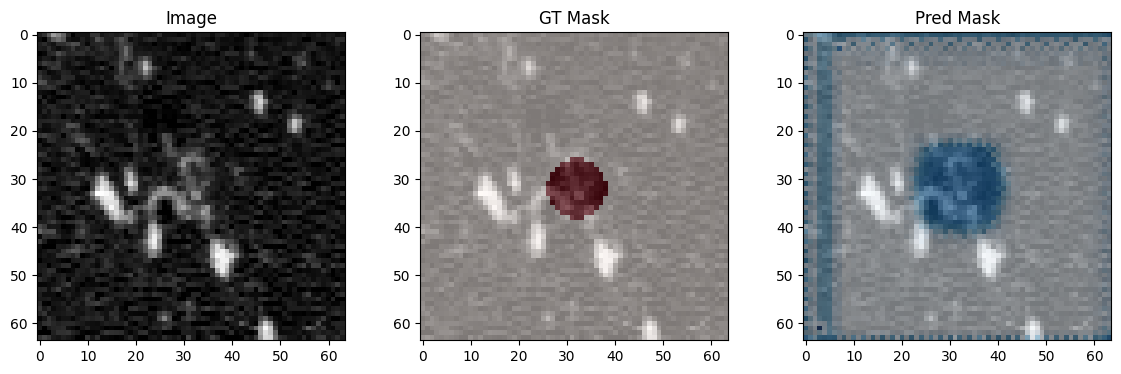

🔥 Saved NEW BEST model (val dice improved)


Epoch 7 val: 100%|██████████| 109/109 [00:04<00:00, 22.73it/s]


Epoch 7/40 | TrainLoss=0.5247 | ValDice=0.0266 | time=26.0s


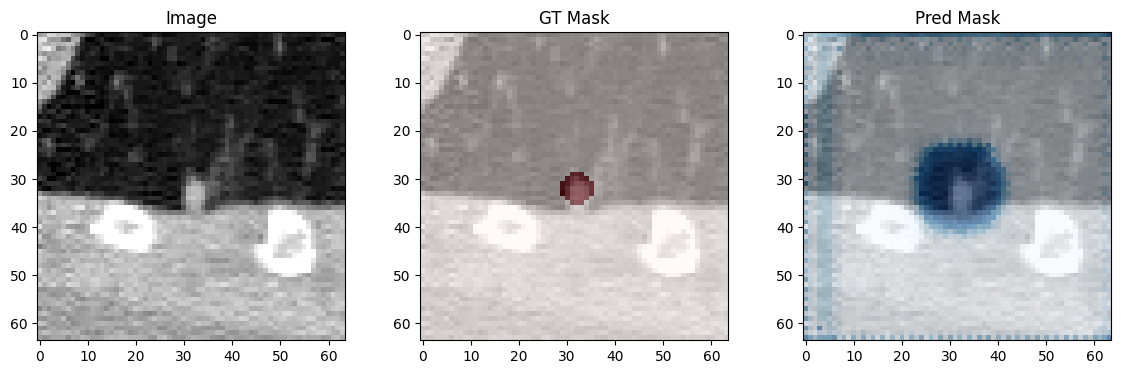

🔥 Saved NEW BEST model (val dice improved)


Epoch 8 val: 100%|██████████| 109/109 [00:04<00:00, 22.50it/s]


Epoch 8/40 | TrainLoss=0.5087 | ValDice=0.0365 | time=25.4s


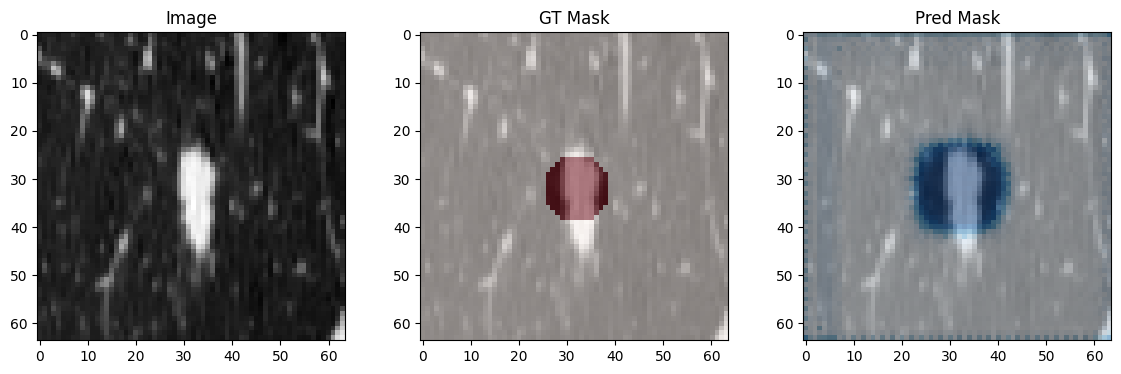

🔥 Saved NEW BEST model (val dice improved)


Epoch 9 val: 100%|██████████| 109/109 [00:04<00:00, 22.22it/s]


Epoch 9/40 | TrainLoss=0.4945 | ValDice=0.0492 | time=26.0s


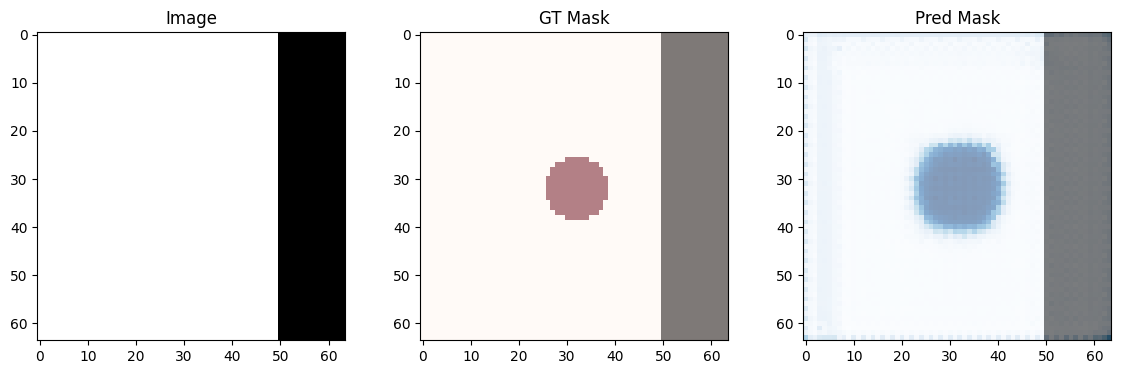

🔥 Saved NEW BEST model (val dice improved)


Epoch 10 val: 100%|██████████| 109/109 [00:04<00:00, 22.77it/s]


Epoch 10/40 | TrainLoss=0.4810 | ValDice=0.0651 | time=25.6s


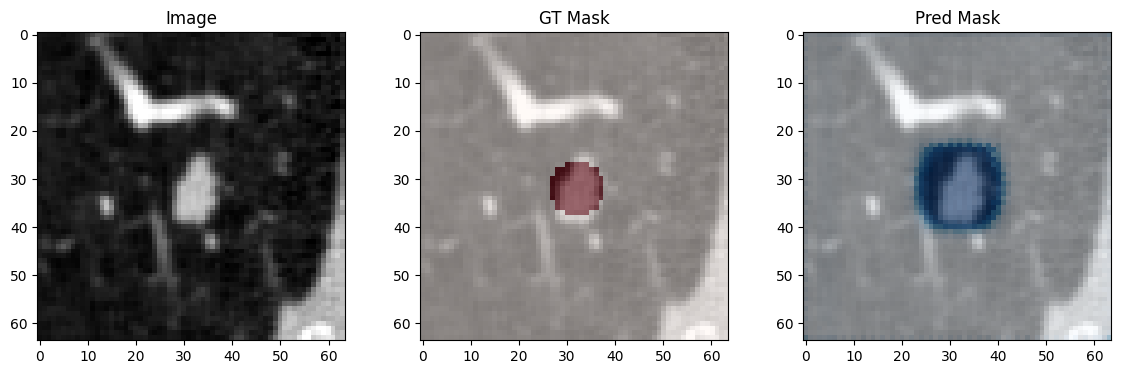

🔥 Saved NEW BEST model (val dice improved)


Epoch 11 val: 100%|██████████| 109/109 [00:04<00:00, 22.63it/s]


Epoch 11/40 | TrainLoss=0.4668 | ValDice=0.0927 | time=25.9s


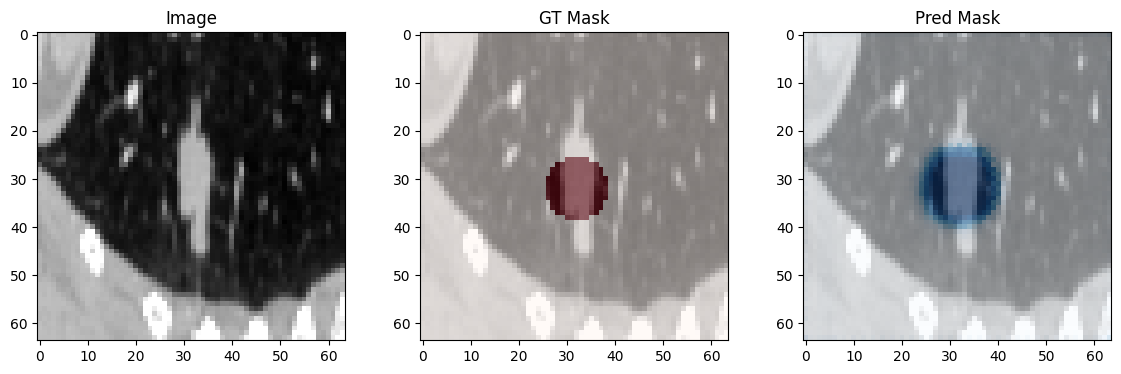

🔥 Saved NEW BEST model (val dice improved)


Epoch 12 val: 100%|██████████| 109/109 [00:05<00:00, 21.47it/s]


Epoch 12/40 | TrainLoss=0.4503 | ValDice=0.1295 | time=26.2s


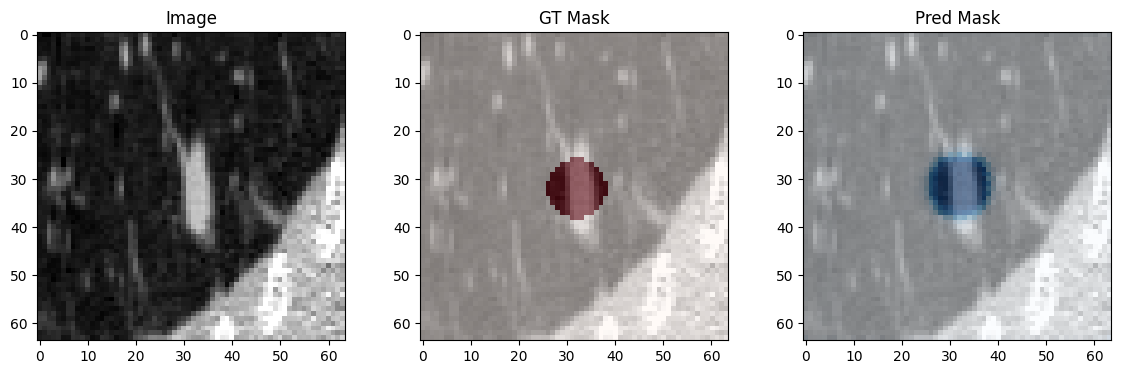

🔥 Saved NEW BEST model (val dice improved)


Epoch 13 val: 100%|██████████| 109/109 [00:04<00:00, 22.95it/s]


Epoch 13/40 | TrainLoss=0.4280 | ValDice=0.1893 | time=25.9s


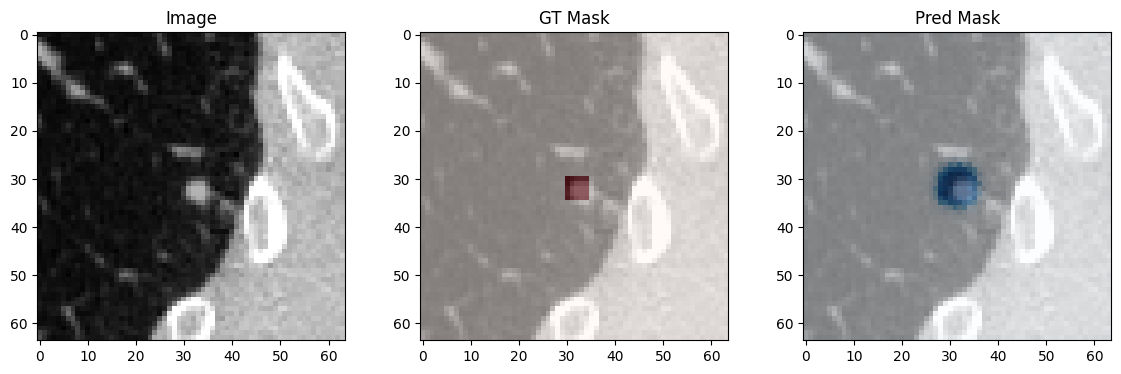

🔥 Saved NEW BEST model (val dice improved)


Epoch 14 val: 100%|██████████| 109/109 [00:05<00:00, 21.50it/s]


Epoch 14/40 | TrainLoss=0.3940 | ValDice=0.2458 | time=26.0s


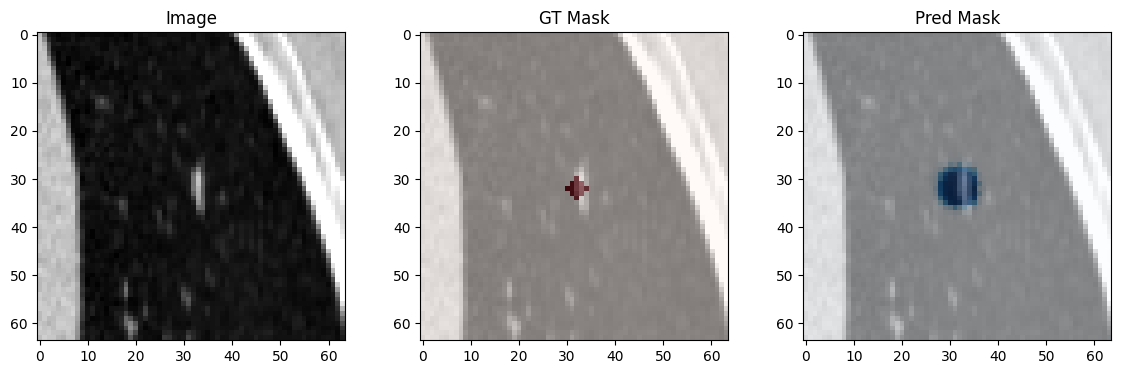

🔥 Saved NEW BEST model (val dice improved)


Epoch 15 val: 100%|██████████| 109/109 [00:04<00:00, 22.51it/s]


Epoch 15/40 | TrainLoss=0.3614 | ValDice=0.3166 | time=26.2s


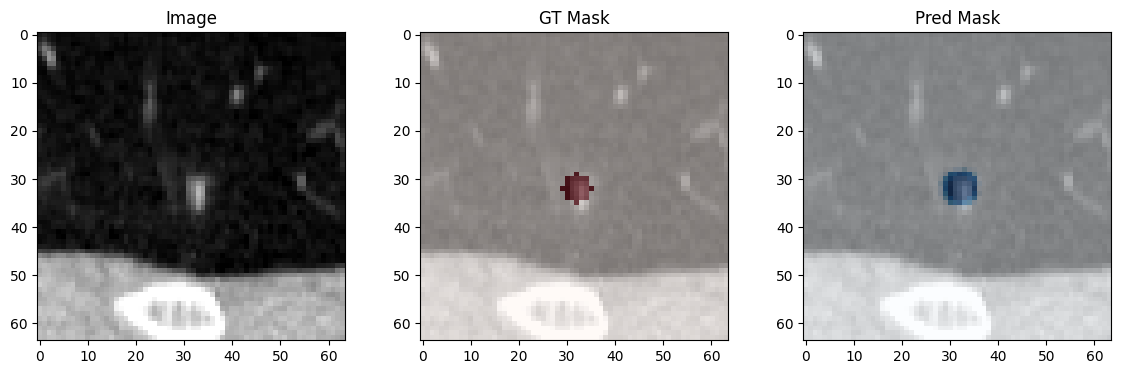

🔥 Saved NEW BEST model (val dice improved)


Epoch 16 val: 100%|██████████| 109/109 [00:04<00:00, 22.07it/s]


Epoch 16/40 | TrainLoss=0.3377 | ValDice=0.3434 | time=26.0s


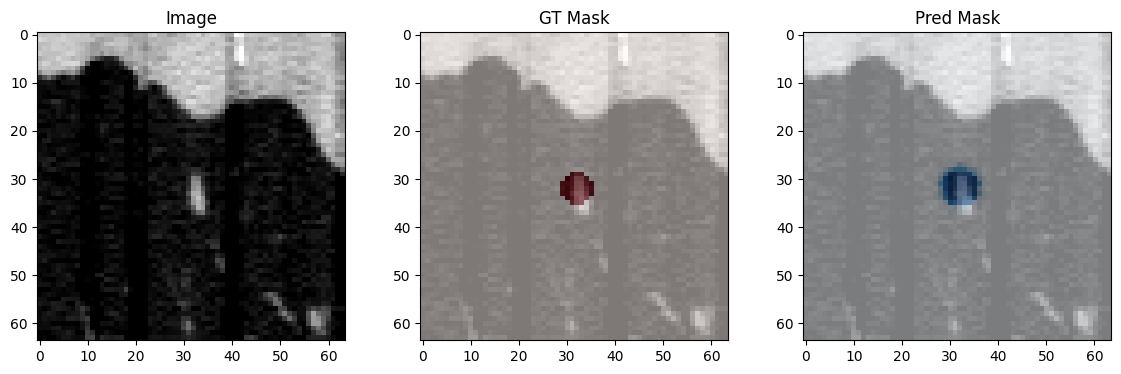

🔥 Saved NEW BEST model (val dice improved)


Epoch 17 val: 100%|██████████| 109/109 [00:05<00:00, 21.06it/s]


Epoch 17/40 | TrainLoss=0.3207 | ValDice=0.3821 | time=25.6s


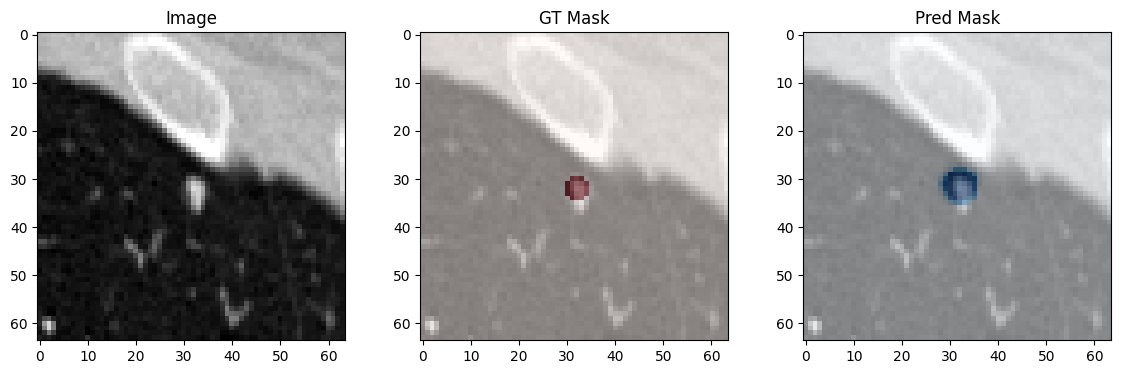

🔥 Saved NEW BEST model (val dice improved)


Epoch 18 val: 100%|██████████| 109/109 [00:04<00:00, 22.33it/s]


Epoch 18/40 | TrainLoss=0.3130 | ValDice=0.3933 | time=25.5s


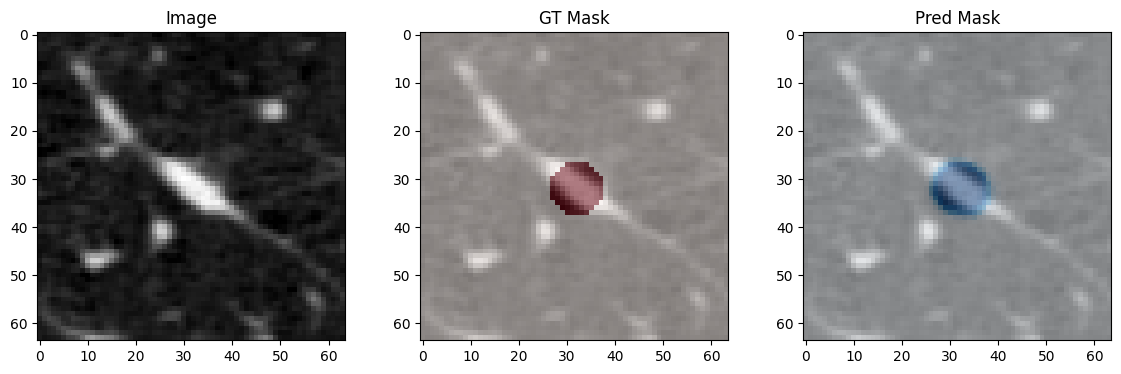

🔥 Saved NEW BEST model (val dice improved)


Epoch 19 val: 100%|██████████| 109/109 [00:04<00:00, 22.54it/s]


Epoch 19/40 | TrainLoss=0.3033 | ValDice=0.3977 | time=25.4s


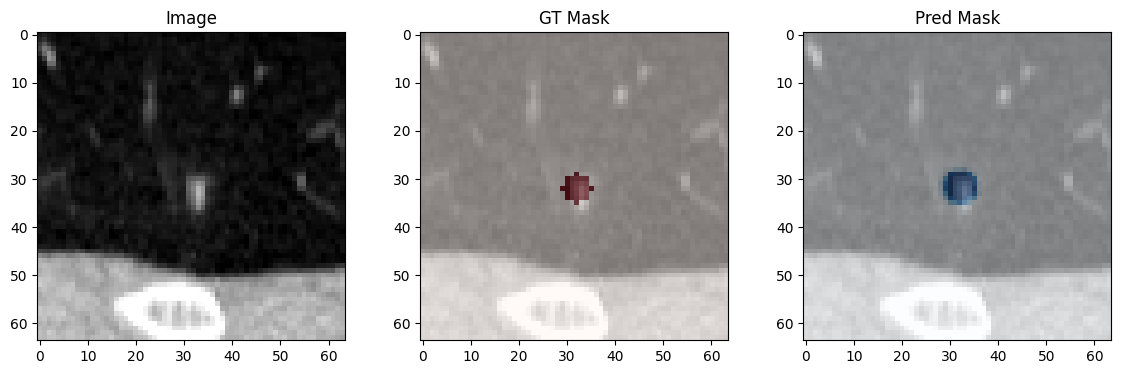

🔥 Saved NEW BEST model (val dice improved)


Epoch 20 val: 100%|██████████| 109/109 [00:04<00:00, 22.25it/s]


Epoch 20/40 | TrainLoss=0.2953 | ValDice=0.4340 | time=26.2s


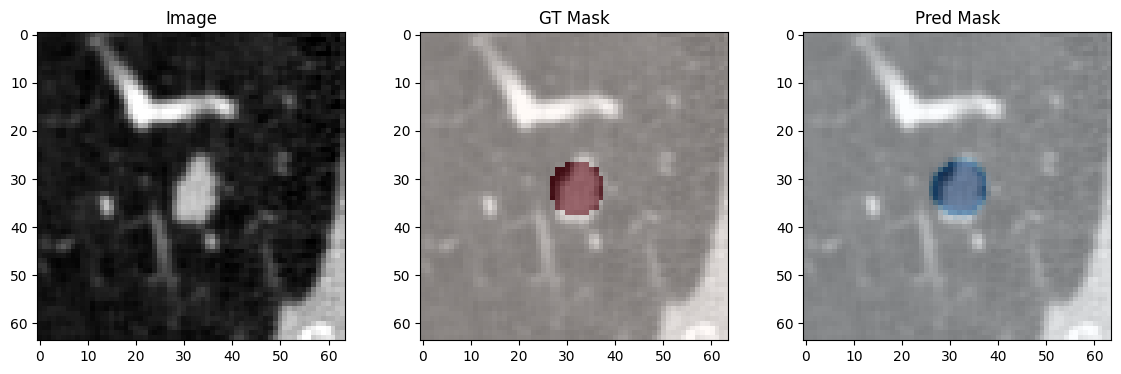

🔥 Saved NEW BEST model (val dice improved)


Epoch 21 val: 100%|██████████| 109/109 [00:04<00:00, 24.09it/s]


Epoch 21/40 | TrainLoss=0.2853 | ValDice=0.4403 | time=25.8s


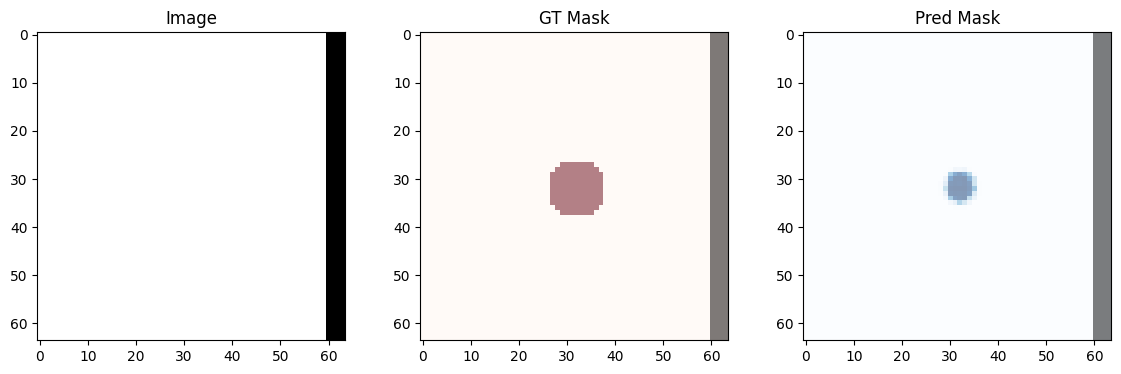

🔥 Saved NEW BEST model (val dice improved)


Epoch 22 val: 100%|██████████| 109/109 [00:05<00:00, 21.56it/s]


Epoch 22/40 | TrainLoss=0.2804 | ValDice=0.4479 | time=26.1s


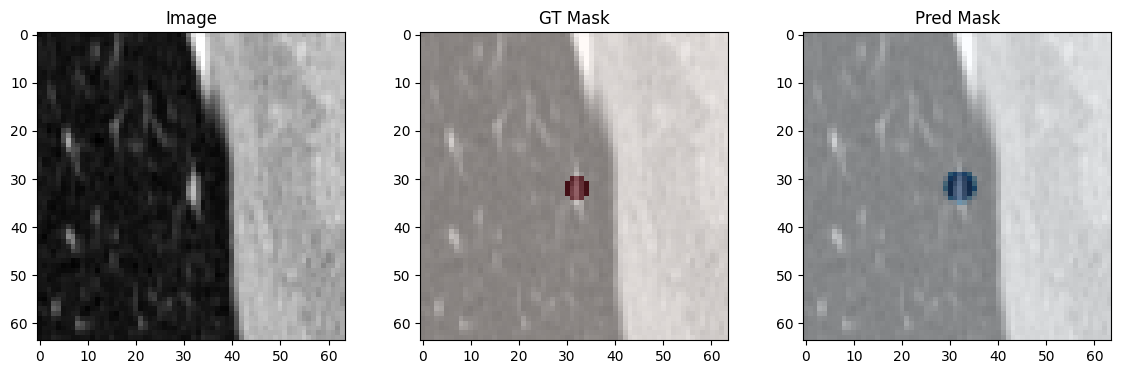

🔥 Saved NEW BEST model (val dice improved)


Epoch 23 val: 100%|██████████| 109/109 [00:04<00:00, 21.96it/s]


Epoch 23/40 | TrainLoss=0.2747 | ValDice=0.4537 | time=25.8s


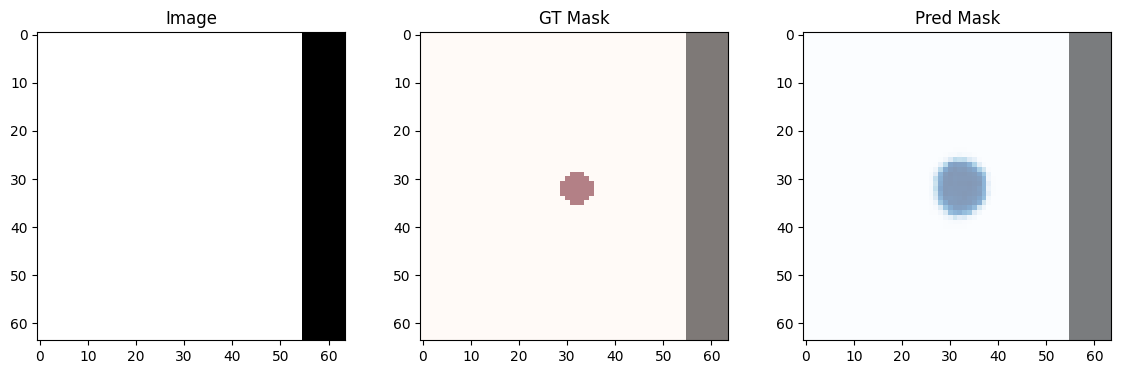

🔥 Saved NEW BEST model (val dice improved)


Epoch 24 val: 100%|██████████| 109/109 [00:04<00:00, 22.85it/s]


Epoch 24/40 | TrainLoss=0.2688 | ValDice=0.4803 | time=26.1s


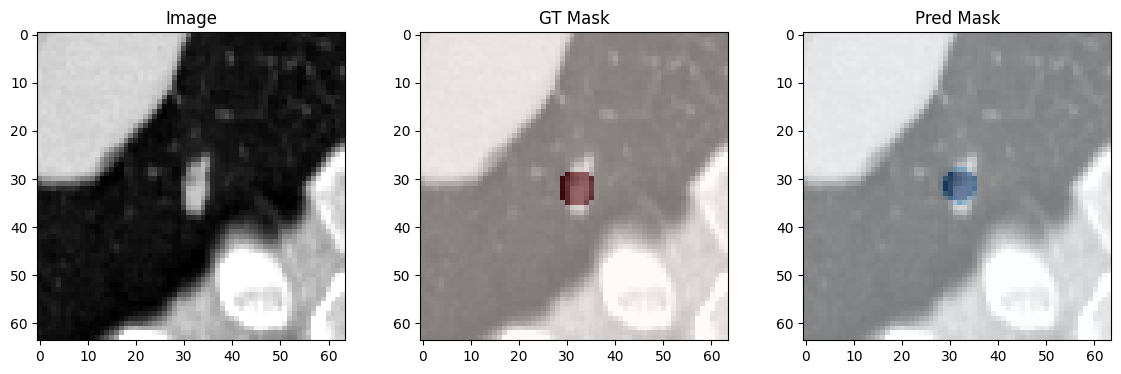

🔥 Saved NEW BEST model (val dice improved)


Epoch 25 val: 100%|██████████| 109/109 [00:05<00:00, 21.79it/s]


Epoch 25/40 | TrainLoss=0.2650 | ValDice=0.4841 | time=25.6s


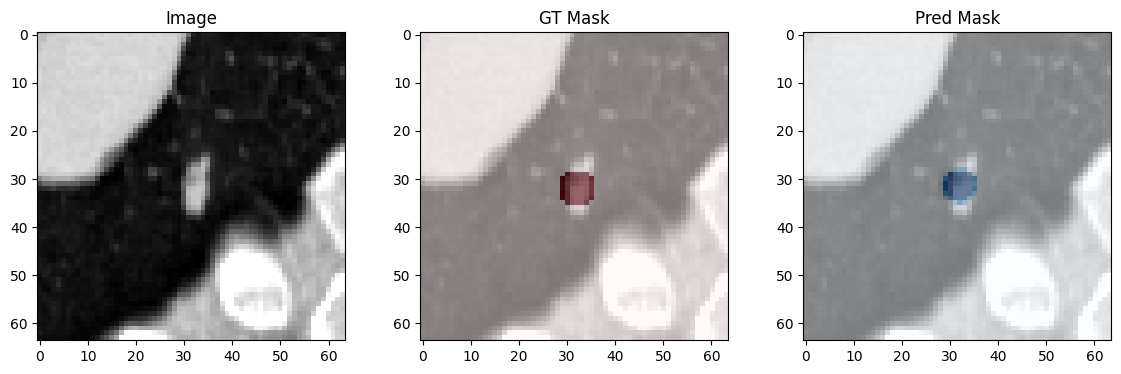

🔥 Saved NEW BEST model (val dice improved)


Epoch 26 val: 100%|██████████| 109/109 [00:05<00:00, 20.85it/s]


Epoch 26/40 | TrainLoss=0.2594 | ValDice=0.4946 | time=26.3s


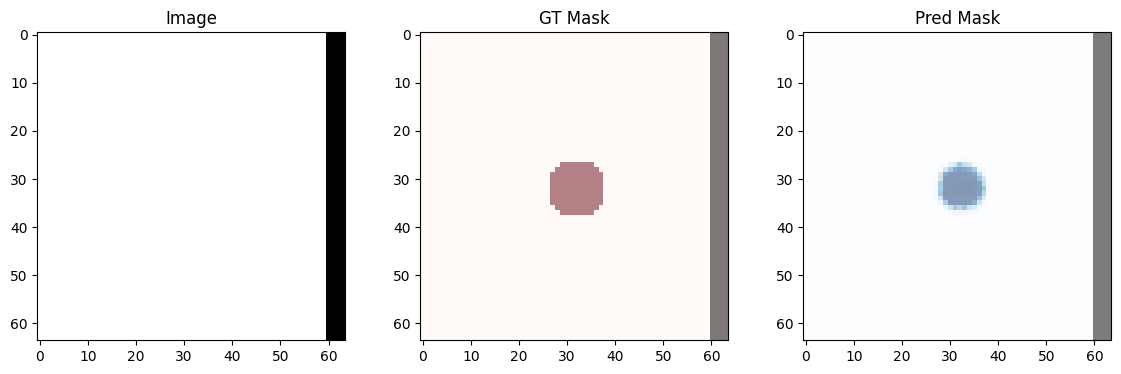

🔥 Saved NEW BEST model (val dice improved)


Epoch 27 val: 100%|██████████| 109/109 [00:04<00:00, 22.62it/s]


Epoch 27/40 | TrainLoss=0.2554 | ValDice=0.4887 | time=26.0s


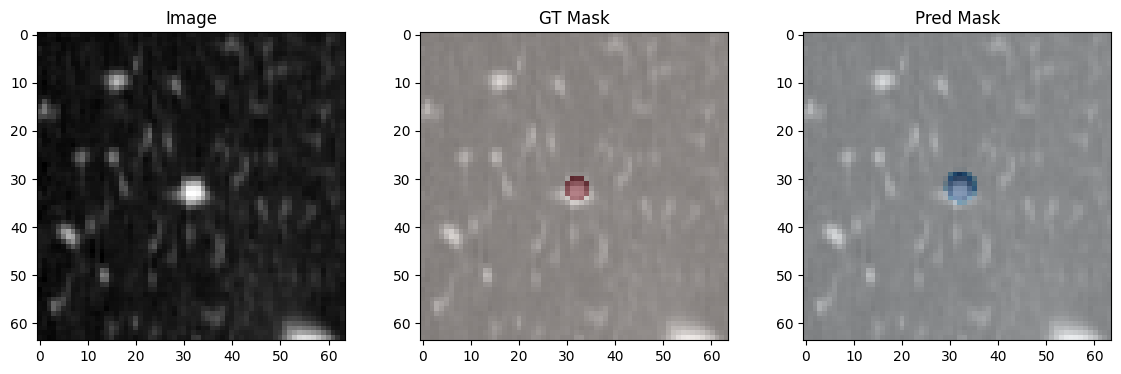

Epoch 28 val: 100%|██████████| 109/109 [00:04<00:00, 22.36it/s]


Epoch 28/40 | TrainLoss=0.2505 | ValDice=0.5089 | time=26.0s


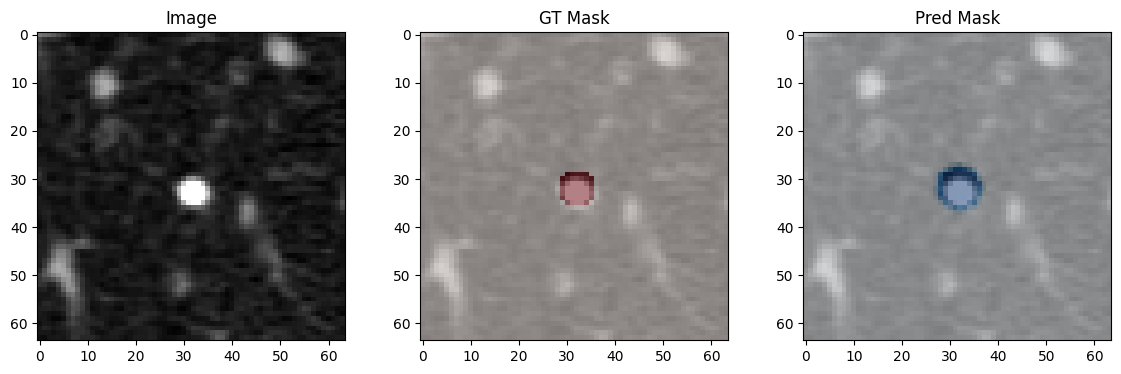

🔥 Saved NEW BEST model (val dice improved)


Epoch 29 val: 100%|██████████| 109/109 [00:04<00:00, 22.21it/s]


Epoch 29/40 | TrainLoss=0.2457 | ValDice=0.5254 | time=25.7s


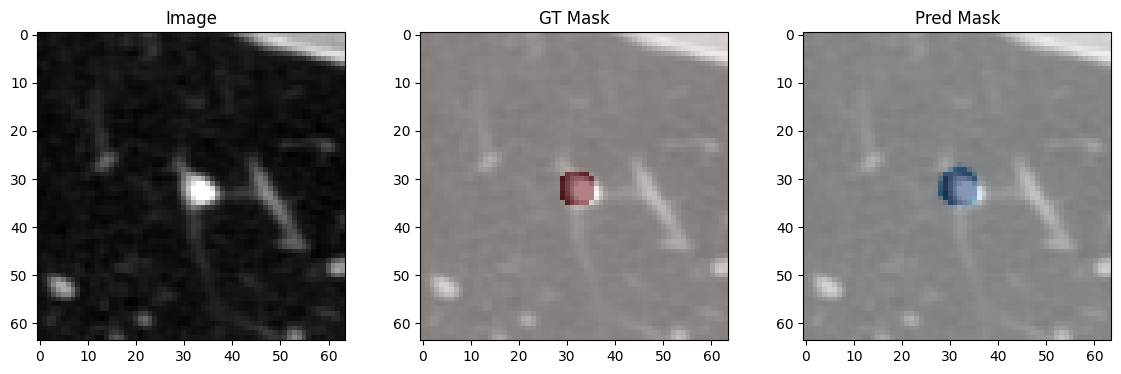

🔥 Saved NEW BEST model (val dice improved)


Epoch 30 val: 100%|██████████| 109/109 [00:04<00:00, 22.67it/s]


Epoch 30/40 | TrainLoss=0.2429 | ValDice=0.5242 | time=25.9s


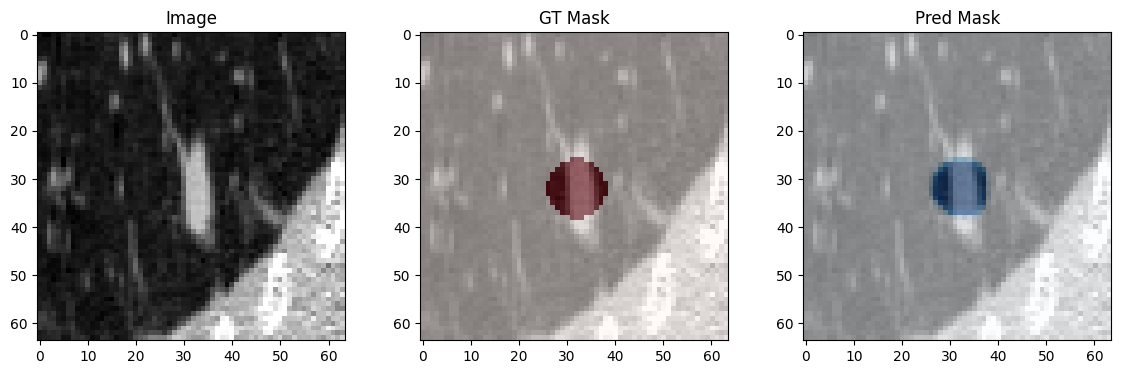

Epoch 31 val: 100%|██████████| 109/109 [00:04<00:00, 22.54it/s]


Epoch 31/40 | TrainLoss=0.2396 | ValDice=0.5165 | time=26.2s


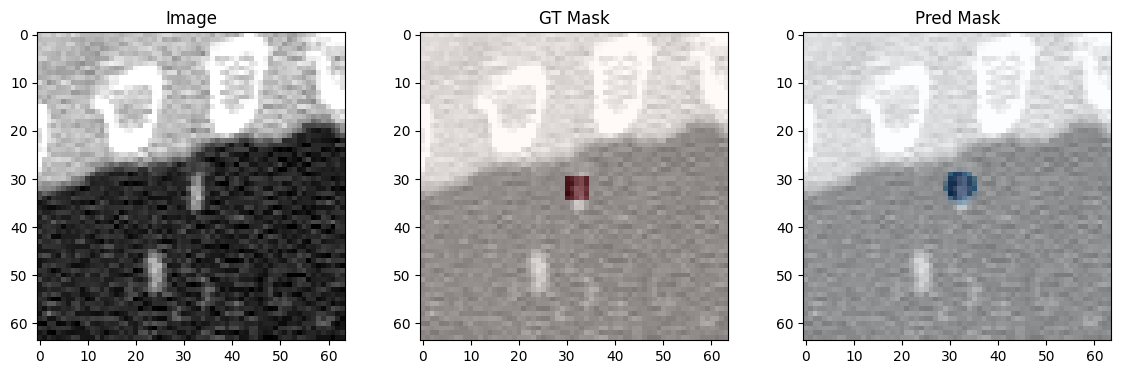

Epoch 32 val: 100%|██████████| 109/109 [00:04<00:00, 22.64it/s]


Epoch 32/40 | TrainLoss=0.2339 | ValDice=0.5314 | time=25.7s


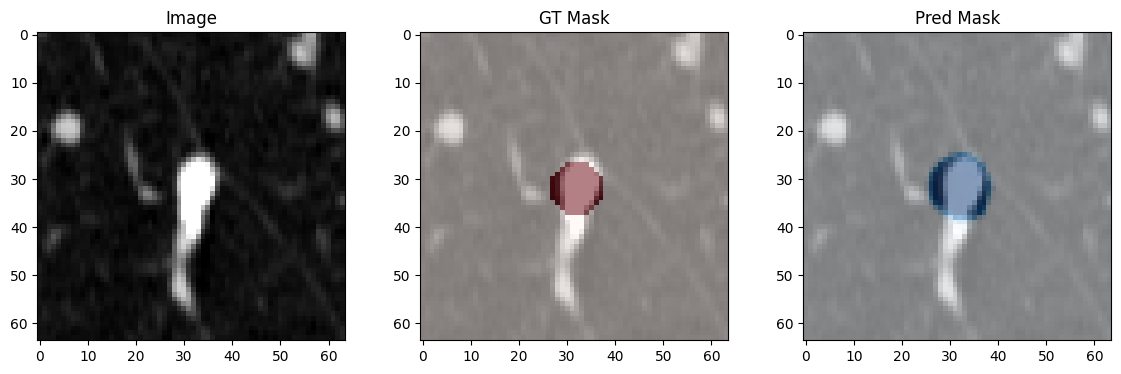

🔥 Saved NEW BEST model (val dice improved)


Epoch 33 val: 100%|██████████| 109/109 [00:04<00:00, 22.81it/s]


Epoch 33/40 | TrainLoss=0.2335 | ValDice=0.5300 | time=25.5s


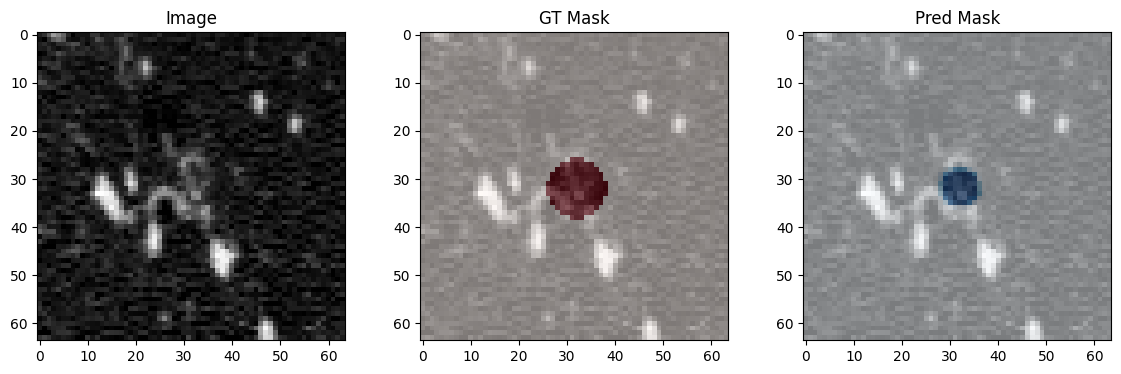

Epoch 34 val: 100%|██████████| 109/109 [00:04<00:00, 22.46it/s]


Epoch 34/40 | TrainLoss=0.2270 | ValDice=0.5572 | time=26.4s


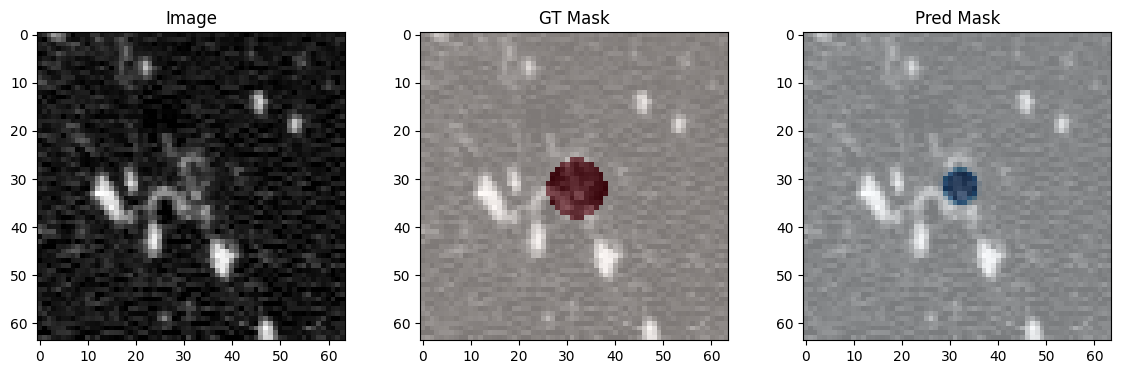

🔥 Saved NEW BEST model (val dice improved)


Epoch 35 val: 100%|██████████| 109/109 [00:04<00:00, 22.61it/s]


Epoch 35/40 | TrainLoss=0.2228 | ValDice=0.5565 | time=25.4s


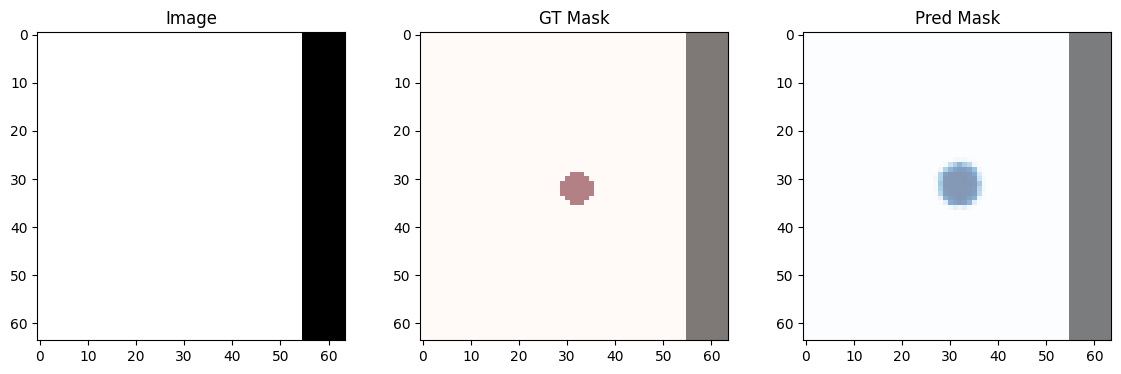

Epoch 36 val: 100%|██████████| 109/109 [00:04<00:00, 22.72it/s]


Epoch 36/40 | TrainLoss=0.2205 | ValDice=0.5527 | time=26.1s


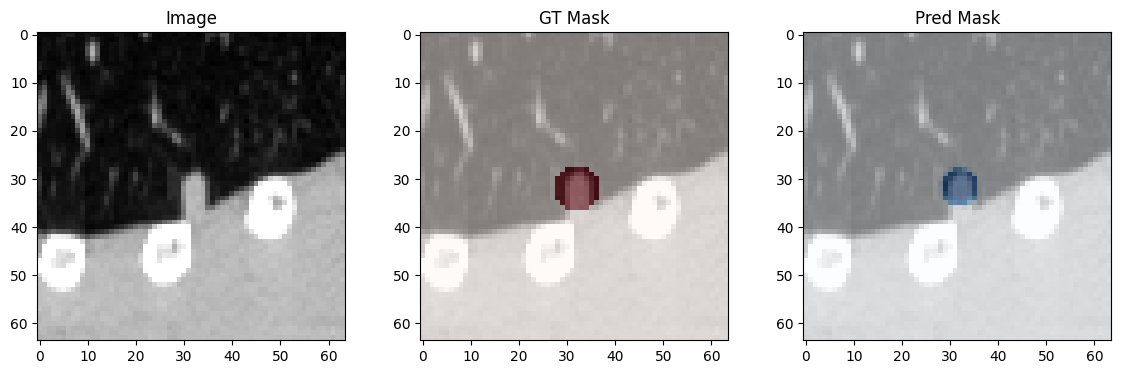

Epoch 37 val: 100%|██████████| 109/109 [00:05<00:00, 21.28it/s]


Epoch 37/40 | TrainLoss=0.2175 | ValDice=0.5613 | time=25.9s


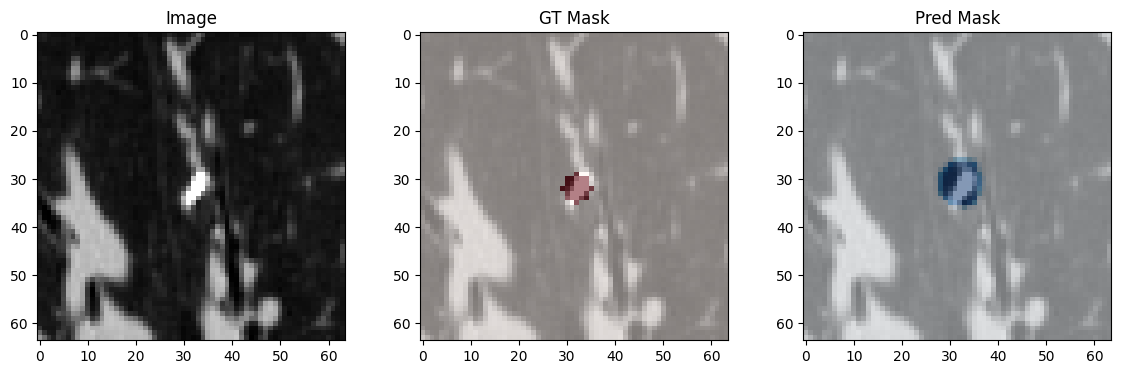

🔥 Saved NEW BEST model (val dice improved)


Epoch 38 val: 100%|██████████| 109/109 [00:04<00:00, 22.92it/s]


Epoch 38/40 | TrainLoss=0.2133 | ValDice=0.5494 | time=26.2s


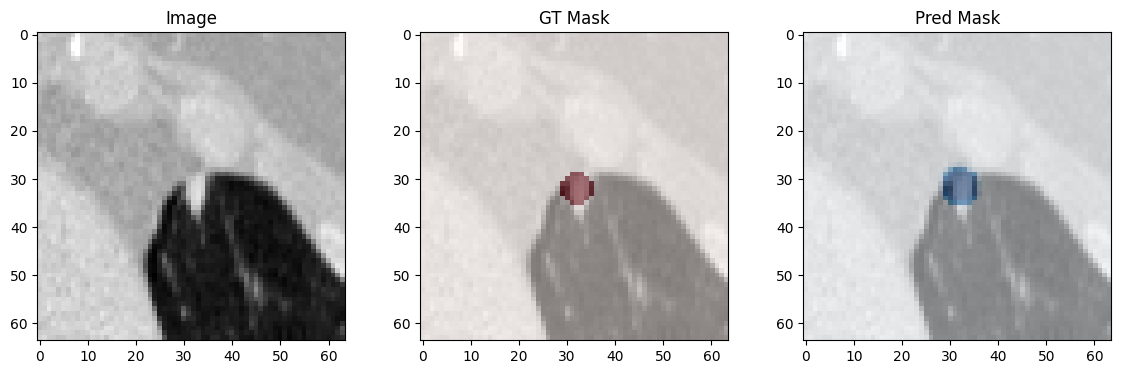

Epoch 39 val: 100%|██████████| 109/109 [00:04<00:00, 22.41it/s]


Epoch 39/40 | TrainLoss=0.2100 | ValDice=0.5693 | time=25.9s


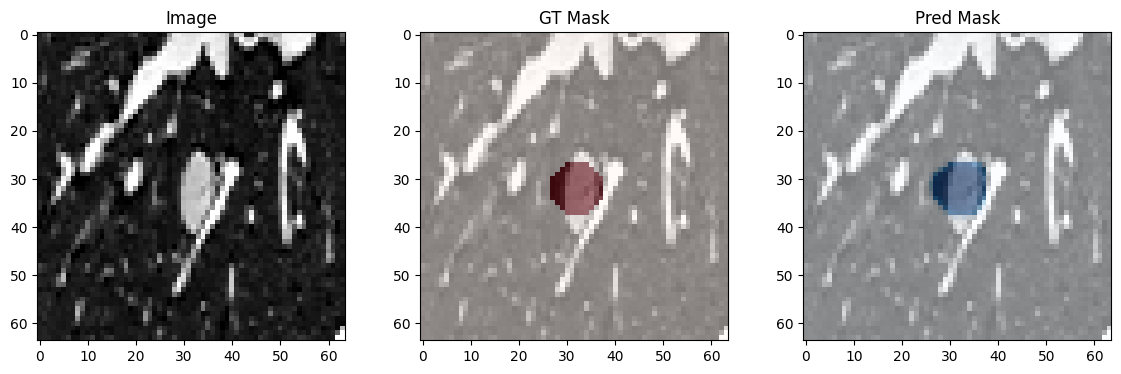

🔥 Saved NEW BEST model (val dice improved)


Epoch 40 val: 100%|██████████| 109/109 [00:05<00:00, 21.42it/s]


Epoch 40/40 | TrainLoss=0.2077 | ValDice=0.5825 | time=26.3s


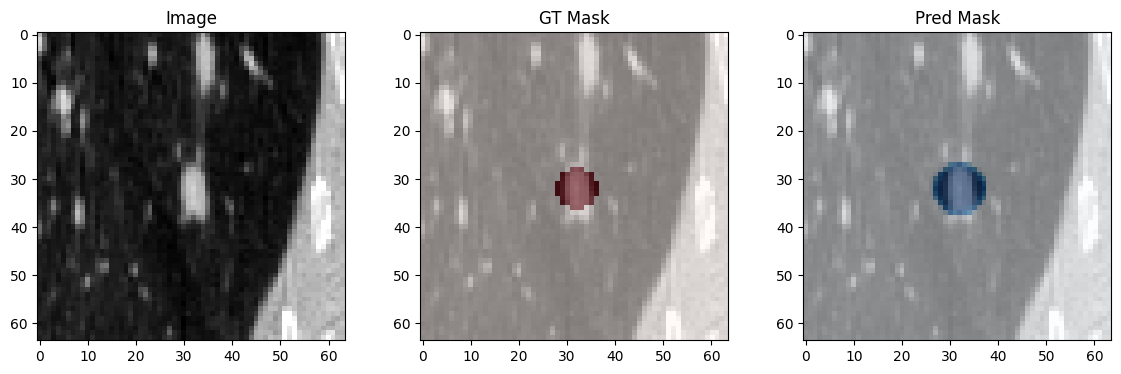

🔥 Saved NEW BEST model (val dice improved)

🎉 Training complete. Best Val Dice: 0.5824716687202454


In [12]:
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler(enabled=(device.type == "cuda"))

best_val = 0.0
patience = 8
no_improve = 0
EPOCHS = 40

for ep in range(1, EPOCHS + 1):
    t0 = time.time()
    unet.train()

    train_loss = 0.0
    n_batches = 0
    # -----------------------
    # TRAIN
    # -----------------------
    for batch in tqdm(train_loader, desc=f"Epoch {ep} train"):
        imgs  = batch["image"].to(device)     # (B,1,64,64,64)
        masks = batch["mask"].to(device)      # (B,1,64,64,64)

        optimizer.zero_grad()

        with autocast(enabled=(device.type == "cuda")):
            preds = unet(imgs)
            loss  = combined_loss(preds, masks)

        # Skip bad gradients
        if not torch.isfinite(loss):
            print("⚠️  Skipping non-finite loss batch")
            continue

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += float(loss)
        n_batches += 1

    train_loss = train_loss / max(1, n_batches)

    # -----------------------
    # VALIDATION
    # -----------------------
    unet.eval()
    dice_metric.reset()

    val_imgs_list = []
    val_preds_list = []
    val_gts_list = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {ep} val"):
            imgs  = batch["image"].to(device)
            masks = batch["mask"].to(device)

            preds = unet(imgs)
            preds_prob = torch.sigmoid(preds)

            dice_metric(y_pred=preds_prob, y=masks)

            # store only first sample from batch for visualization
            val_imgs_list.append(imgs[0].cpu())
            val_preds_list.append(preds_prob[0].cpu())
            val_gts_list.append(masks[0].cpu())

    val_dice = float(dice_metric.aggregate().item())
    dice_metric.reset()

    # Scheduler: high metric = good → step on val_dice
    scheduler.step(val_dice)

    print(f"Epoch {ep}/{EPOCHS} | TrainLoss={train_loss:.4f} | ValDice={val_dice:.4f} | time={time.time()-t0:.1f}s")

    # -----------------------
    # VISUALIZATION
    # -----------------------
    idx = random.randint(0, len(val_preds_list)-1)
    if len(val_preds_list) > 0:
        show_prediction(
        val_imgs_list[idx],   # (1,64,64,64)
        val_gts_list[idx],    # (1,64,64,64)
        val_preds_list[idx]   # (1,64,64,64)
        )


    # -----------------------
    # SAVE CHECKPOINTS
    # -----------------------
    ckpt_last = OUTPUT_DIR / "unet_last.pt"
    torch.save({"model_state_dict": unet.state_dict(), "epoch": ep}, ckpt_last)

    if val_dice > best_val:
        best_val = val_dice
        ckpt_best = OUTPUT_DIR / "unet_best.pt"
        torch.save({"model_state_dict": unet.state_dict(), "epoch": ep}, ckpt_best)
        print("🔥 Saved NEW BEST model (val dice improved)")
        no_improve = 0
    else:
        no_improve += 1

    # Early stop
    if no_improve >= patience:
        print("⛔ Early stopping triggered.")
        break

print("\n🎉 Training complete. Best Val Dice:", best_val)


In [13]:
# Cell 10 - post training quick sanity
ckpt = OUTPUT_DIR / "unet_best.pt"
ck = torch.load(ckpt, map_location=device)
unet.load_state_dict(ck["model_state_dict"])
unet.eval()

# run a small subset inference and show metrics
preds, gts = [], []
with torch.no_grad():
    for i, batch in enumerate(val_loader):
        imgs = batch["image"].to(device); masks = batch["mask"].to(device)
        p = torch.sigmoid(unet(imgs))
        preds.append((p.cpu().numpy()>0.5).astype(int))
        gts.append(masks.cpu().numpy().astype(int))
        if i>=20: break

# compute mean Dice manually
def dice_np(pred, gt, eps=1e-6):
    inter = (pred & gt).sum()
    return (2*inter) / (pred.sum() + gt.sum() + eps)

dices = [dice_np(preds[i].squeeze(), gts[i].squeeze()) for i in range(len(preds))]
print("Sample mean Dice:", np.nanmean(dices))


Sample mean Dice: 0.7556865916123201


In [22]:
import pandas as pd
dataset = pd.read_csv("preprocessed_fleischner_fixed/metadata_fleischner_final.csv")

In [23]:
dataset

,uid,image,mask,diameter_mm,texture_code,texture_class,fleischner_7class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,5.651471,5.0,ground-glass,3
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,4.224708,5.0,ground-glass,3
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,5.786348,5.0,ground-glass,3
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,8.143262,5.0,ground-glass,6
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,18.545150,5.0,ground-glass,6
...,...,...,...,...,...,...,...
1079,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,5.053694,5.0,ground-glass,3
1080,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,4.556101,5.0,ground-glass,3
1081,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,4.357368,5.0,ground-glass,3
1082,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,4.277203,5.0,ground-glass,3


In [24]:
label_map = {"solid":0, "part-solid":1, "ground-glass":2}
inv_label_map = {v:k for k,v in label_map.items()}

In [25]:
dataset['label_3class'] = dataset['texture_class'].map(label_map)
dataset['label_3class'] = dataset['label_3class'].astype(int)

In [26]:
dataset

,uid,image,mask,diameter_mm,texture_code,texture_class,fleischner_7class,label_3class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,5.651471,5.0,ground-glass,3,2
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,4.224708,5.0,ground-glass,3,2
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,5.786348,5.0,ground-glass,3,2
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,8.143262,5.0,ground-glass,6,2
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,18.545150,5.0,ground-glass,6,2
...,...,...,...,...,...,...,...,...
1079,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,5.053694,5.0,ground-glass,3,2
1080,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,4.556101,5.0,ground-glass,3,2
1081,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,4.357368,5.0,ground-glass,3,2
1082,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,4.277203,5.0,ground-glass,3,2


In [30]:
dataset['label_3class'].value_counts()

label_3class
2    950
1    110
0     24
Name: count, dtype: int64

In [28]:
dataset['image'] = dataset['image'].apply(fix_path)
dataset['mask'] = dataset['mask'].apply(fix_path)

In [29]:
dataset

,uid,image,mask,diameter_mm,texture_code,texture_class,fleischner_7class,label_3class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,5.651471,5.0,ground-glass,3,2
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,4.224708,5.0,ground-glass,3,2
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,5.786348,5.0,ground-glass,3,2
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,8.143262,5.0,ground-glass,6,2
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,18.545150,5.0,ground-glass,6,2
...,...,...,...,...,...,...,...,...
1079,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,5.053694,5.0,ground-glass,3,2
1080,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,4.556101,5.0,ground-glass,3,2
1081,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,4.357368,5.0,ground-glass,3,2
1082,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,4.277203,5.0,ground-glass,3,2


In [32]:
dataset.to_csv('metadataCLF.csv',index=False)